In [1]:
from sklearn.datasets import make_moons
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import os , sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from core.optimization import NSGAConfig, run_nsga
from core.cf_problem import make_cf_problem
from core.data import DataGenerator, DatasetsDG
from core.models import SimpleNN,EnsembleModel
from matplotlib import pyplot as plt
from utils import plot_proba, plot_uncertainty_heatmap, plot_cf_3d

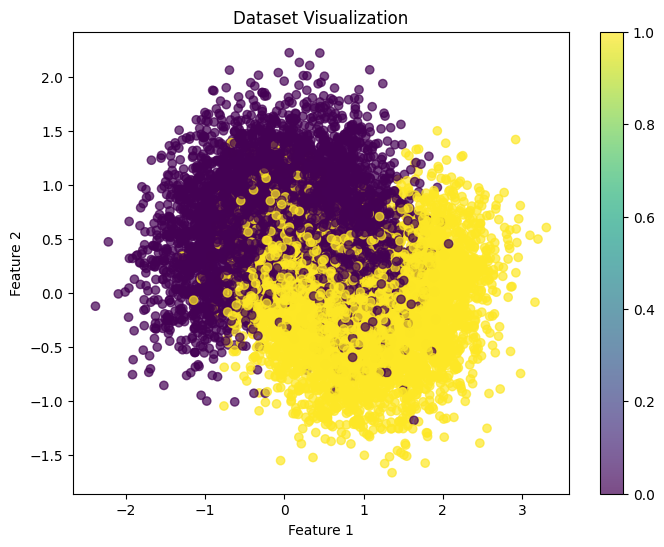

In [2]:
ds=make_moons(n_samples=10000, noise=0.4, random_state=42)

tds = TensorDataset(torch.tensor(ds[0], dtype=torch.float32), torch.tensor(ds[1], dtype=torch.long))
dg=DatasetsDG(tds, num_classes=2)
dg.plot()

In [3]:
models = [SimpleNN(input_dim=2, hidden_dim=8, output_dim=2, depth=3) for _ in range(5)]
ensemble_model = EnsembleModel(models=models)


# train each model in the ensemble
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble_model.to(device)
epochs = 50
val_data = dg.sample(2000, seed=123)
for model in ensemble_model.models:
    seed = 42 + hash(model) % 1000  # Simple way to get different seeds
    samples = dg.sample(5000, seed=seed)
    _tds= TensorDataset(samples[0].to(device), samples[1].to(device))
    DL=DataLoader(_tds, batch_size=256, shuffle=True)
    model.train()
    bar = tqdm(range(epochs), desc="Training Model", colour="blue", unit="epoch")
    running_loss = 0.0
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    for epoch in bar:
        for inputs, labels in DL:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        bar.set_postfix({"loss": running_loss / (epoch + 1)})
    
    model.eval()
    with torch.no_grad():
        val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
        val_outputs = model(val_inputs)
        _, val_preds = torch.max(val_outputs, 1)
        _, val_labels_idx = torch.max(val_labels, 1)
        val_accuracy = (val_preds == val_labels_idx).float().mean().item()
        print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
    print(f"Finished Training Model")

Training Model: 100%|██████████| 50/50 [00:05<00:00,  9.75epoch/s, loss=7.67]



Validation Accuracy: 86.90%
Finished Training Model


Training Model: 100%|██████████| 50/50 [00:03<00:00, 12.67epoch/s, loss=7.86]



Validation Accuracy: 86.10%
Finished Training Model


Training Model: 100%|██████████| 50/50 [00:04<00:00, 11.99epoch/s, loss=7.38]



Validation Accuracy: 86.80%
Finished Training Model


Training Model: 100%|██████████| 50/50 [00:04<00:00, 12.12epoch/s, loss=7.67]



Validation Accuracy: 86.65%
Finished Training Model


Training Model: 100%|██████████| 50/50 [00:04<00:00, 12.20epoch/s, loss=9.04]

Validation Accuracy: 83.85%
Finished Training Model


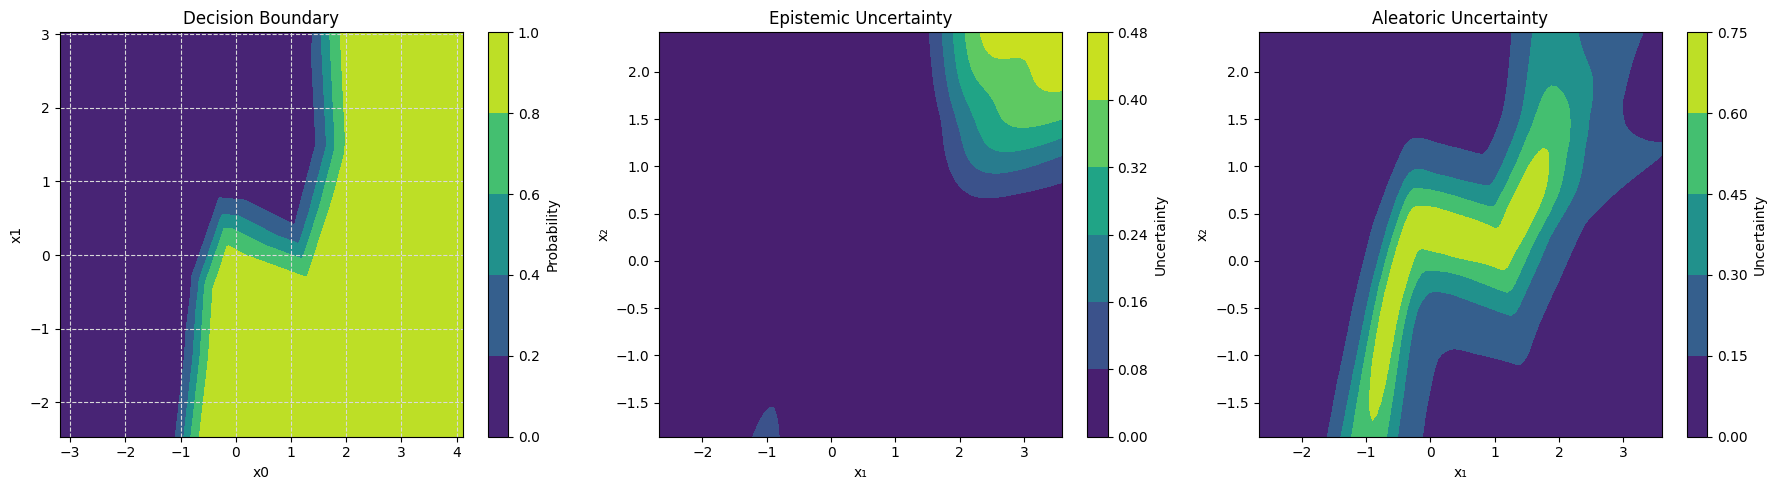

In [4]:
# plot decision boundary


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

plot_proba(ensemble_model.models[0], ds[0], levels=5, ax=axes[0])
axes[0].set_title("Decision Boundary")

plot_uncertainty_heatmap(ensemble_model, ds[0], uncertainty_type="epistemic", device=device, levels=5, ax=axes[1])
axes[1].set_title("Epistemic Uncertainty")

plot_uncertainty_heatmap(ensemble_model, ds[0], uncertainty_type="aleatoric", device=device, levels=5, ax=axes[2])
axes[2].set_title("Aleatoric Uncertainty")

plt.tight_layout()
plt.show()

In [5]:
x_factual = torch.tensor([[2, -1]], dtype=torch.float32)
y_target = torch.tensor([0], dtype=torch.long)
problem = make_cf_problem(ensemble_model.models[0], x_factual, y_target, torch.tensor(dg.sample(1000, seed=456)[0], dtype=torch.float32), device=device)

NSGA2_config = NSGAConfig(
    pop_size=150,
    min_gen=150,
    max_gen=450,
)
results = run_nsga(problem, NSGA2_config)

C:\Users\yuanl\AppData\Local\Temp\ipykernel_59620\3237351130.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  problem = make_cf_problem(ensemble_model.models[0], x_factual, y_target, torch.tensor(dg.sample(1000, seed=456)[0], dtype=torch.float32), device=device)


Gen    1 | Valid CFs (pop):  67 | Valid CFs (archive):  42 | Best P(target): 1.000 | Mean Sparsity: 0.422
Gen   10 | Valid CFs (pop):  98 | Valid CFs (archive):  98 | Best P(target): 1.000 | Mean Sparsity: 0.373
Gen   10 | Valid CFs (pop):  98 | Valid CFs (archive):  98 | Best P(target): 1.000 | Mean Sparsity: 0.373
Gen   20 | Valid CFs (pop):  98 | Valid CFs (archive):  98 | Best P(target): 1.000 | Mean Sparsity: 0.381
Gen   20 | Valid CFs (pop):  98 | Valid CFs (archive):  98 | Best P(target): 1.000 | Mean Sparsity: 0.381
Gen   30 | Valid CFs (pop):  96 | Valid CFs (archive):  96 | Best P(target): 1.000 | Mean Sparsity: 0.375
Gen   30 | Valid CFs (pop):  96 | Valid CFs (archive):  96 | Best P(target): 1.000 | Mean Sparsity: 0.375
Gen   40 | Valid CFs (pop):  97 | Valid CFs (archive):  97 | Best P(target): 1.000 | Mean Sparsity: 0.379
Gen   40 | Valid CFs (pop):  97 | Valid CFs (archive):  97 | Best P(target): 1.000 | Mean Sparsity: 0.379
Gen   50 | Valid CFs (pop):  98 | Valid CFs (a

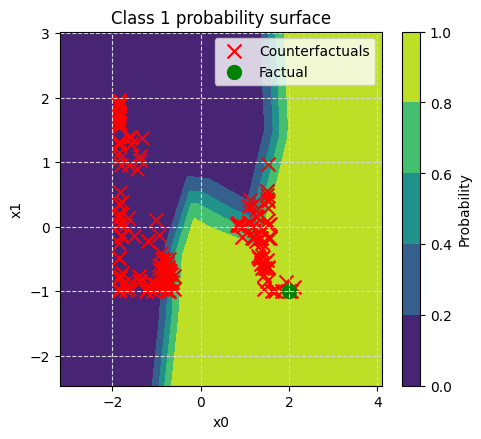

In [6]:
fig,ax=plot_proba(ensemble_model.models[0], ds[0], levels=5)
cf_samples = torch.tensor(results.X, dtype=torch.float32).cpu().numpy()
ax.scatter(cf_samples[:, 0], cf_samples[:, 1], color='red', marker='x', s=100, label='Counterfactuals')
ax.scatter(x_factual[0, 0].item(), x_factual[0, 1].item(), color='green', marker='o', s=100, label='Factual')
ax.legend()

In [18]:
import importlib
import utils
importlib.reload(utils)
from utils import plot_cf_3d

plot_cf_3d(results=results, x_factual=x_factual, context=dg.sample(10000, seed=789)[0])